In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# load data
train_data = pd.read_csv(r"~/.kaggle/competitions/titanic/train.csv")
test_data = pd.read_csv(r"~/.kaggle/competitions/titanic/test.csv")
train_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
# 欠損があるかの確認
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# 欠損値を平均値で埋める
from sklearn.preprocessing import Imputer
def nan_padding(data, columns):
    for column in columns:
        imputer=Imputer(missing_values='NaN', strategy='mean', axis=0)#
        data[column]=imputer.fit_transform(data[column].values.reshape(-1,1))
    return data

nan_columns = ["Age", "SibSp", "Parch"]

train_data = nan_padding(train_data, nan_columns)
test_data = nan_padding(test_data, nan_columns)
train_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0.0,0.0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0.0,0.0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1.0,2.0,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0.0,0.0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.000000,0.0,0.0,370376,7.75,NaN,Q


In [6]:
#save PassengerId for evaluation
test_passenger_id=test_data["PassengerId"]
test_passenger_id;

In [7]:
# いらない部分を削除
def drop_not_concerned(data, columns):
    return data.drop(columns, axis=1)

not_concerned_columns = ["PassengerId","Name", "Ticket", "Fare", "Cabin", "Embarked"]
train_data = drop_not_concerned(train_data, not_concerned_columns)
test_data = drop_not_concerned(test_data, not_concerned_columns)
test_data.tail()

,Pclass,Sex,Age,SibSp,Parch
413,3,male,30.27259,0.0,0.0
414,1,female,39.00000,0.0,0.0
415,3,male,38.50000,0.0,0.0
416,3,male,30.27259,0.0,0.0
417,3,male,30.27259,1.0,1.0


In [8]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)
    return data


dummy_columns = ["Pclass"]
train_data=dummy_data(train_data, dummy_columns)
test_data=dummy_data(test_data, dummy_columns)
test_data.tail()

,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
413,male,30.27259,0.0,0.0,0,0,1
414,female,39.00000,0.0,0.0,1,0,0
415,male,38.50000,0.0,0.0,0,0,1
416,male,30.27259,0.0,0.0,0,0,1
417,male,30.27259,1.0,1.0,0,0,1


In [9]:
from sklearn.preprocessing import LabelEncoder
def sex_to_int(data):
    le = LabelEncoder()
    le.fit(["male","female"])
    data["Sex"]=le.transform(data["Sex"]) 
    return data

train_data = sex_to_int(train_data)
test_data = sex_to_int(test_data)
test_data.tail()

,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
413,1,30.27259,0.0,0.0,0,0,1
414,0,39.00000,0.0,0.0,1,0,0
415,1,38.50000,0.0,0.0,0,0,1
416,1,30.27259,0.0,0.0,0,0,1
417,1,30.27259,1.0,1.0,0,0,1


In [10]:
from sklearn.preprocessing import MinMaxScaler

def normalize_age(data):
    scaler = MinMaxScaler()
    data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))
    return data
train_data = normalize_age(train_data)
test_data = normalize_age(test_data)
test_data.tail()

,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3
413,1,0.396975,0.0,0.0,0,0,1
414,0,0.512066,0.0,0.0,1,0,0
415,1,0.505473,0.0,0.0,0,0,1
416,1,0.396975,0.0,0.0,0,0,1
417,1,0.396975,1.0,1.0,0,0,1


In [11]:
# 評価にしている。　学習データ、評価データ、予測データ
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

def split_valid_test_data(data, fraction=(1 - 0.8)):
    #目的変数を抽出
    data_y = data["Survived"]
    lb = LabelBinarizer()
    data_y = lb.fit_transform(data_y)
    
    #目的変数を消す
    data_x = data.drop(["Survived"], axis=1)
    
    #pandasで分ける
    train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=fraction)

    return train_x.values, train_y, valid_x, valid_y

train_x, train_y, valid_x, valid_y = split_valid_test_data(train_data)
print("train_x:{}".format(train_x.shape))
print("train_y:{}".format(train_y.shape))
print("train_y content:{}".format(train_y[:3]))

print("valid_x:{}".format(valid_x.shape))
print("valid_y:{}".format(valid_y.shape))

train_x:(712, 7)
train_y:(712, 1)
train_y content:[[1]
 [0]
 [0]]
valid_x:(179, 7)
valid_y:(179, 1)


In [13]:
# Build Neural Network
from collections import namedtuple

def build_neural_network(hidden_units=10):
    tf.reset_default_graph()
    inputs = tf.placeholder(tf.float32, shape=[None, train_x.shape[1]])
    labels = tf.placeholder(tf.float32, shape=[None, 1])
    learning_rate = tf.placeholder(tf.float32)#学習レート
    is_training=tf.Variable(True,dtype=tf.bool)#重み
    
    initializer = tf.contrib.layers.xavier_initializer()#重みの初期値の与え方
    fc = tf.layers.dense(inputs, hidden_units, activation=None,kernel_initializer=initializer)#
    fc= tf.layers.batch_normalization(fc, training=is_training)
    fc= tf.nn.relu(fc)
    
    #出力層
    logits = tf.layers.dense(fc, 1, activation=None)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    cost = tf.reduce_mean(cross_entropy)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    predicted = tf.nn.sigmoid(logits)
    correct_pred = tf.equal(tf.round(predicted), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Export the nodes 
    export_nodes = ['inputs', 'labels', 'learning_rate','is_training', 'logits',
                    'cost', 'optimizer', 'predicted', 'accuracy']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])

    return graph

model = build_neural_network()
model

Graph(inputs=<tf.Tensor 'Placeholder:0' shape=(?, 7) dtype=float32>, labels=<tf.Tensor 'Placeholder_1:0' shape=(?, 1) dtype=float32>, learning_rate=<tf.Tensor 'Placeholder_2:0' shape=<unknown> dtype=float32>, is_training=<tf.Variable 'Variable:0' shape=() dtype=bool_ref>, logits=<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1) dtype=float32>, cost=<tf.Tensor 'Mean:0' shape=() dtype=float32>, optimizer=<tf.Operation 'Adam' type=NoOp>, predicted=<tf.Tensor 'Sigmoid:0' shape=(?, 1) dtype=float32>, accuracy=<tf.Tensor 'Mean_1:0' shape=() dtype=float32>)

In [52]:
def get_batch(data_x,data_y,batch_size=32):
    batch_n=len(data_x)//batch_size
    print(batch_n)
    for i in range(batch_n):
        batch_x=data_x[i*batch_size:(i+1)*batch_size]
        batch_y=data_y[i*batch_size:(i+1)*batch_size]
        
        yield batch_x,batch_y

In [29]:
epochs = 200#学習周回数
train_collect = 100#学習状況収集
train_print=train_collect*2#学習状況表示

learning_rate_value = 0.001
batch_size=16

x_collect = []
train_loss_collect = []
train_acc_collect = []
valid_loss_collect = []
valid_acc_collect = []

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    iteration=0
    for e in range(epochs):
        for batch_x,batch_y in get_batch(train_x,train_y,batch_size):
            iteration+=1
            feed = {model.inputs: train_x,
                    model.labels: train_y,
                    model.learning_rate: learning_rate_value,
                    model.is_training:True
                   }

            train_loss, _, train_acc = sess.run([model.cost, model.optimizer, model.accuracy], feed_dict=feed)
            
            if iteration % train_collect == 0:
                x_collect.append(e)
                train_loss_collect.append(train_loss)
                train_acc_collect.append(train_acc)

                if iteration % train_print==0:
                     print("Epoch: {}/{}".format(e + 1, epochs),
                      "Train Loss: {:.4f}".format(train_loss),
                      "Train Acc: {:.4f}".format(train_acc))
                        
                feed = {model.inputs: valid_x,
                        model.labels: valid_y,
                        model.is_training:False
                       }
                val_loss, val_acc = sess.run([model.cost, model.accuracy], feed_dict=feed)
                valid_loss_collect.append(val_loss)
                valid_acc_collect.append(val_acc)
                
                if iteration % train_print==0:
                    print("Epoch: {}/{}".format(e + 1, epochs),
                      "Validation Loss: {:.4f}".format(val_loss),
                      "Validation Acc: {:.4f}".format(val_acc))
                

    saver.save(sess, "./titanic.ckpt")

Epoch: 3/200 Train Loss: 0.5220 Train Acc: 0.7753
Epoch: 3/200 Validation Loss: 0.5881 Validation Acc: 0.7151
Epoch: 5/200 Train Loss: 0.4463 Train Acc: 0.8076
Epoch: 5/200 Validation Loss: 0.5364 Validation Acc: 0.7598
Epoch: 7/200 Train Loss: 0.4187 Train Acc: 0.8160
Epoch: 7/200 Validation Loss: 0.4767 Validation Acc: 0.7877
Epoch: 10/200 Train Loss: 0.4122 Train Acc: 0.8230
Epoch: 10/200 Validation Loss: 0.4445 Validation Acc: 0.7821
Epoch: 12/200 Train Loss: 0.4096 Train Acc: 0.8258
Epoch: 12/200 Validation Loss: 0.4322 Validation Acc: 0.7933
Epoch: 14/200 Train Loss: 0.4080 Train Acc: 0.8244
Epoch: 14/200 Validation Loss: 0.4274 Validation Acc: 0.7989
Epoch: 16/200 Train Loss: 0.4070 Train Acc: 0.8244
Epoch: 16/200 Validation Loss: 0.4260 Validation Acc: 0.8045
Epoch: 19/200 Train Loss: 0.4057 Train Acc: 0.8258
Epoch: 19/200 Validation Loss: 0.4275 Validation Acc: 0.8045
Epoch: 21/200 Train Loss: 0.4049 Train Acc: 0.8244
Epoch: 21/200 Validation Loss: 0.4259 Validation Acc: 0.804

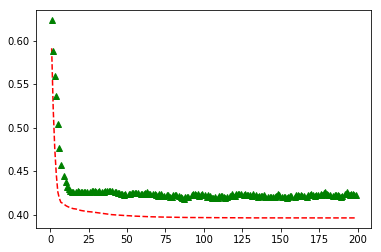

In [30]:
plt.plot(x_collect, train_loss_collect, "r--")
plt.plot(x_collect, valid_loss_collect, "g^")
plt.show()

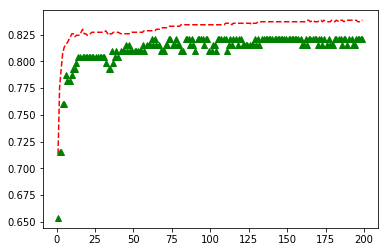

In [31]:
plt.plot(x_collect, train_acc_collect, "r--")
plt.plot(x_collect, valid_acc_collect, "g^")
plt.show()

In [32]:
model=build_neural_network()
restorer=tf.train.Saver()
with tf.Session() as sess:
    restorer.restore(sess,"./titanic.ckpt")
    feed={
        model.inputs:test_data,
        model.is_training:False
    }
    test_predict=sess.run(model.predicted,feed_dict=feed)
    
test_predict[:10]

INFO:tensorflow:Restoring parameters from ./titanic.ckpt


array([[0.1146331 ],
       [0.48062006],
       [0.01921315],
       [0.12839922],
       [0.71030223],
       [0.11493554],
       [0.5921271 ],
       [0.27295035],
       [0.5980785 ],
       [0.05940513]], dtype=float32)

In [33]:
from sklearn.preprocessing import Binarizer
binarizer=Binarizer(0.5)
test_predict_result=binarizer.fit_transform(test_predict)
test_predict_result=test_predict_result.astype(np.int32)
test_predict_result[:10]

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]], dtype=int32)

In [34]:
passenger_id=test_passenger_id.copy()
evaluation=passenger_id.to_frame()
evaluation["Survived"]=test_predict_result
evaluation[:10]

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [35]:
evaluation.to_csv("evaluation_submission.csv",index=False)